In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

import warnings
import time
warnings.filterwarnings("ignore")

In [2]:
sample_1 = pd.read_csv("Donor Data Sample2.csv")
sample_1.shape

(87016, 12)

In [3]:
def remove_rows_containg_all_null_values(df):
    idx = df.index[~df.isnull().all(1)]
    df = df.ix[idx]
    return df

def identify_years_columns(df):
    column_names = df.columns
    return [col for col in column_names if "20" in col]

def identify_info_columns(df):
    column_names = df.columns
    return [col for col in column_names if "20" not in col]

## Remove column contains 80% unique values and more than 50% null values
def remove_columns_unique_values(df, column_names):
    final_col_=[]
    number_of_sample = df.shape[0]
    print("Total training samples: {}".format(number_of_sample))
    for col in column_names:
        print("Column: {}, Null count: {}".format(col, df[col].isnull().sum()))
        if df[col].isnull().sum() <= number_of_sample/2:
            final_col_.append(col)
    final_col=[]
    print("_____________\n")
    for col in final_col_:
        print("Column: {}, Unique count: {}".format(col, df[col].unique().shape[0]))
        if (df[col].unique().shape[0] <= number_of_sample*0.8) and (df[col].unique().shape[0]!=1) :
            final_col.append(col)
    final_df = df[final_col]
    final_df.fillna("", inplace=True)
    return final_df

def identify_categorical_columns(df, column_names):
    cat_col_=[]
    for col in column_names:
        if df[col].unique().shape[0] <=5:
            cat_col_.append(col)
    return cat_col_

def text_processing(text):
    pre_text=[]
    for x in text:
        x = re.sub('[^a-zA-Z.\d\s]', '', x)
        x = re.sub(' +', ' ', x)
        x = str(x.strip()).lower()
        pre_text.append(x)
    return pre_text

In [4]:
## Process Donor information columns

df = remove_rows_containg_all_null_values(sample_1)
print(df.shape)
df_info = remove_columns_unique_values(df, identify_info_columns(sample_1))
cat_col = identify_categorical_columns(df, df_info)
print("Categorical columns: {}".format(cat_col))

df_info['comb_text'] = df_info.apply(lambda x: ' '.join(x), axis=1)
processed_text = text_processing(list(df_info['comb_text']))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_text)
tfidf_matrix = X.todense()
tfidf_matrix.shape

(18827, 12)
Total training samples: 18827
Column: unique Code, Null count: 0
Column: Donor Name, Null count: 6218
Column: Donated Nonprofit Name, Null count: 0
Column: STREET, Null count: 0
Column: CITY, Null count: 0
Column: STATE, Null count: 0
Column: ZIP, Null count: 0
_____________

Column: unique Code, Unique count: 18827
Column: Donor Name, Unique count: 10645
Column: Donated Nonprofit Name, Unique count: 5433
Column: STREET, Unique count: 13373
Column: CITY, Unique count: 1148
Column: STATE, Unique count: 1
Column: ZIP, Unique count: 13910
Categorical columns: []


(18827, 35253)

In [5]:
donation_columns = df[identify_years_columns(df)].fillna("0")
donation_columns = donation_columns.astype(str)

def clean_donation(donation):
    donation = ''.join(c for c in donation if (c.isdigit()) | (c == "."))
    if donation == "":
        return "0"
    else:
        return donation

for col in donation_columns.columns:
    donation_columns[col] = donation_columns[col].apply(lambda x: clean_donation(x))
    donation_columns[col] = donation_columns[col].astype(float)
    
donation_columns = donation_columns.astype(int)

no_of_col = donation_columns.shape[1]
columns = donation_columns.columns
last_year = "2019"
previous_years = [col for col in columns if last_year not in col]
last_year_columns = [col for col in columns if last_year in col][0]
print(previous_years, last_year_columns)
donation_columns['moving_avg_2019'] = donation_columns.sum(axis=1)/no_of_col
donation_columns['moving_avg_2018'] = donation_columns[previous_years].sum(axis=1)/(no_of_col-1)
donation_columns['target'] = donation_columns[last_year_columns].apply(lambda x: 1 if x>0 else 0)
donation_columns.sample(5)

[' 2018 Amount ', ' 2017 Amount ', ' 2016 Amount ', ' 2015 Amount ']  2019 Amount 


,2019 Amount,2018 Amount,2017 Amount,2016 Amount,2015 Amount,moving_avg_2019,moving_avg_2018,target
6946,330,1425,578,545,328,641.2,719.0,1
14199,0,0,0,0,0,0.0,0.0,0
17058,0,0,0,0,0,0.0,0.0,0
1970,0,0,0,0,0,0.0,0.0,0
2235,0,846,1167,968,649,726.0,907.5,0


## correlation plot

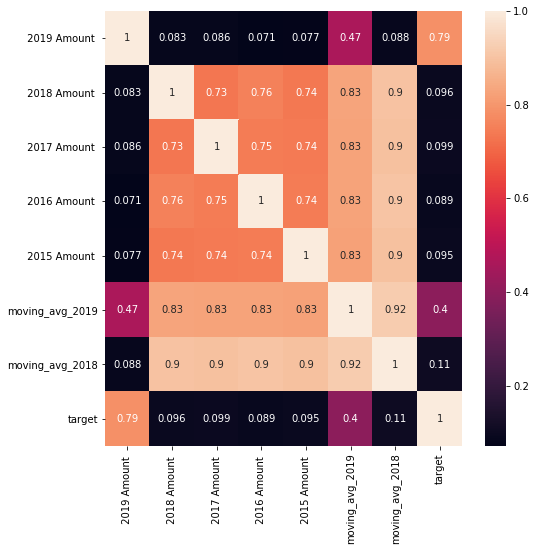

In [7]:
fig, ax = plt.subplots(figsize=(8,8)) 
ax = sn.heatmap(donation_columns.corr(),annot=True)

In [6]:
newCol = [[x] for x in list(donation_columns['moving_avg_2018'])]
X = np.append(tfidf_matrix, newCol, 1)
y = list(donation_columns['target'])
print(tfidf_matrix.shape)
print(X.shape)

(18827, 35253)
(18827, 35254)


In [7]:
models = [{'label': 'Logistic Regression', 'model': LogisticRegression()},
          {'label': 'GaussianNB', 'model': GaussianNB()},
          {'label': 'MultinomialNB', 'model': MultinomialNB()},
          {'label': 'ComplementNB', 'model': ComplementNB()},
          {'label': 'BernoulliNB', 'model': BernoulliNB()},
          {'label': 'DecisionTreeClassifier', 'model': DecisionTreeClassifier()},
          {'label': 'SGDClassifier', 'model': SGDClassifier(loss='log')},
          {'label': 'PassiveAggressiveClassifier', 'model': PassiveAggressiveClassifier()}, #No predict_proba
          {'label': 'LinearSVC', 'model': LinearSVC()}, #No predict_proba
          {'label': 'RandomForestClassifier', 'model': RandomForestClassifier()}]

Classifier: Logistic Regression and time(seconds): 4.48
Classifier: GaussianNB and time(seconds): 46.617
Classifier: MultinomialNB and time(seconds): 3.825
Classifier: ComplementNB and time(seconds): 3.376
Classifier: BernoulliNB and time(seconds): 15.646
Classifier: DecisionTreeClassifier and time(seconds): 307.365
Classifier: SGDClassifier and time(seconds): 74.219
Classifier: PassiveAggressiveClassifier and time(seconds): 44.833
Classifier: LinearSVC and time(seconds): 4.176
Classifier: RandomForestClassifier and time(seconds): 57.753


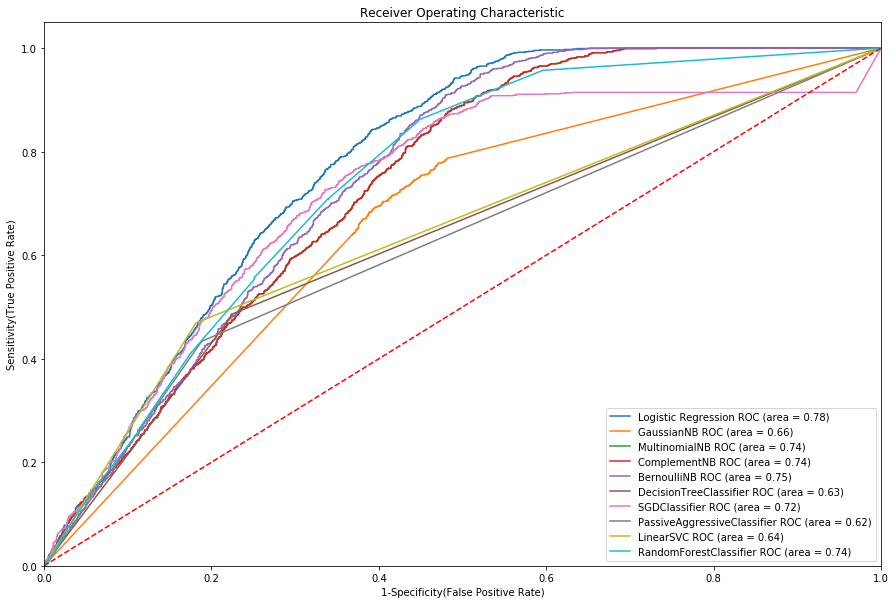

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# models = [{'label': 'RandomForestClassifier', 'model': RandomForestClassifier()}]
#           {'label': 'RandomForestClassifier', 'model': RandomForestClassifier()}]

plt.figure(figsize=(15,10))
y_pred_model={}
for m in models:
    start_time = time.time()
    model = m['model']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Classifier: {} and time(seconds): {}".format(m['label'], round(time.time()-start_time, 3)))
    y_pred_model[m['label']] = y_pred
    try:
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    except:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="{} ROC (area = {})".format(m['label'], round(auc,2)))
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
def print_confusion_matrix_classification_report(y_test, y_pred):
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,fmt="d", annot_kws={"size": 16}) # font size
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    print("classification report")
    print(classification_report(y_test, y_pred))
    print("___________________________\n")

Classifier: Logistic Regression and f1-score 0.68


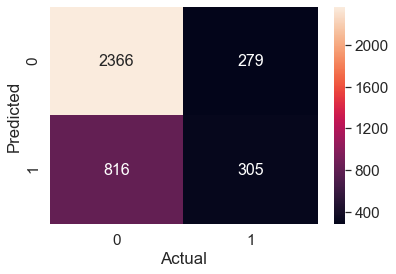

classification report
              precision    recall  f1-score   support

           0       0.74      0.89      0.81      2645
           1       0.52      0.27      0.36      1121

    accuracy                           0.71      3766
   macro avg       0.63      0.58      0.58      3766
weighted avg       0.68      0.71      0.68      3766

___________________________

Classifier: GaussianNB and f1-score 0.65


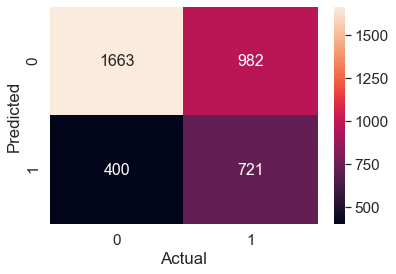

classification report
              precision    recall  f1-score   support

           0       0.81      0.63      0.71      2645
           1       0.42      0.64      0.51      1121

    accuracy                           0.63      3766
   macro avg       0.61      0.64      0.61      3766
weighted avg       0.69      0.63      0.65      3766

___________________________

Classifier: MultinomialNB and f1-score 0.62


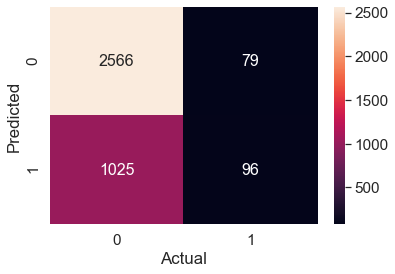

classification report
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      2645
           1       0.55      0.09      0.15      1121

    accuracy                           0.71      3766
   macro avg       0.63      0.53      0.49      3766
weighted avg       0.67      0.71      0.62      3766

___________________________

Classifier: ComplementNB and f1-score 0.62


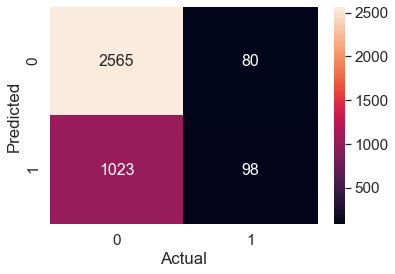

classification report
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      2645
           1       0.55      0.09      0.15      1121

    accuracy                           0.71      3766
   macro avg       0.63      0.53      0.49      3766
weighted avg       0.67      0.71      0.62      3766

___________________________

Classifier: BernoulliNB and f1-score 0.67


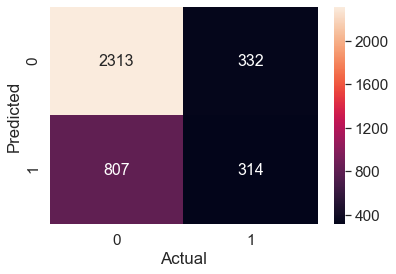

classification report
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      2645
           1       0.49      0.28      0.36      1121

    accuracy                           0.70      3766
   macro avg       0.61      0.58      0.58      3766
weighted avg       0.67      0.70      0.67      3766

___________________________

Classifier: DecisionTreeClassifier and f1-score 0.69


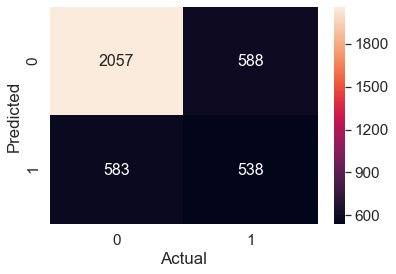

classification report
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      2645
           1       0.48      0.48      0.48      1121

    accuracy                           0.69      3766
   macro avg       0.63      0.63      0.63      3766
weighted avg       0.69      0.69      0.69      3766

___________________________

Classifier: SGDClassifier and f1-score 0.68


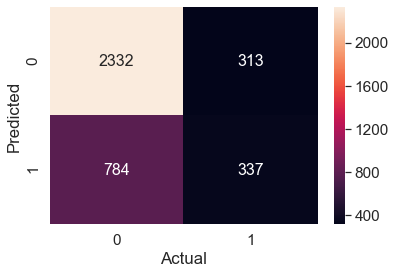

classification report
              precision    recall  f1-score   support

           0       0.75      0.88      0.81      2645
           1       0.52      0.30      0.38      1121

    accuracy                           0.71      3766
   macro avg       0.63      0.59      0.60      3766
weighted avg       0.68      0.71      0.68      3766

___________________________

Classifier: PassiveAggressiveClassifier and f1-score 0.69


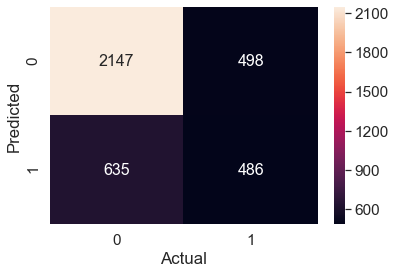

classification report
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      2645
           1       0.49      0.43      0.46      1121

    accuracy                           0.70      3766
   macro avg       0.63      0.62      0.63      3766
weighted avg       0.69      0.70      0.69      3766

___________________________

Classifier: LinearSVC and f1-score 0.71


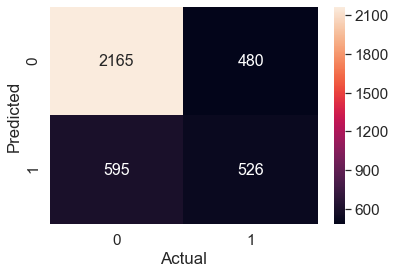

classification report
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      2645
           1       0.52      0.47      0.49      1121

    accuracy                           0.71      3766
   macro avg       0.65      0.64      0.65      3766
weighted avg       0.71      0.71      0.71      3766

___________________________

Classifier: RandomForestClassifier and f1-score 0.67


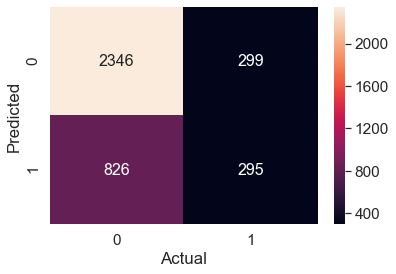

classification report
              precision    recall  f1-score   support

           0       0.74      0.89      0.81      2645
           1       0.50      0.26      0.34      1121

    accuracy                           0.70      3766
   macro avg       0.62      0.58      0.58      3766
weighted avg       0.67      0.70      0.67      3766

___________________________



In [14]:
model_f1_score={}
for model, y_pred in y_pred_model.items():
    model_f1_score[model] = round(f1_score(y_test, y_pred, average='weighted'), 2)
    print("Classifier: {} and f1-score {}".format(model, round(f1_score(y_test, y_pred, average='weighted'), 2)))
    print_confusion_matrix_classification_report(y_test, y_pred)

In [15]:
{k: v for k, v in sorted(model_f1_score.items(), key=lambda item: item[1])}

{'MultinomialNB': 0.62,
 'ComplementNB': 0.62,
 'GaussianNB': 0.65,
 'BernoulliNB': 0.67,
 'RandomForestClassifier': 0.67,
 'Logistic Regression': 0.68,
 'SGDClassifier': 0.68,
 'DecisionTreeClassifier': 0.69,
 'PassiveAggressiveClassifier': 0.69,
 'LinearSVC': 0.71}

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model_features={}
for m in models:
    start_time = time.time()
    model = m['model']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        model.coef_
        print(m['label'], "coef exits")
    except Exception as e:
        print(m['label'], e)

Logistic Regression coef exits
GaussianNB 'GaussianNB' object has no attribute 'coef_'
MultinomialNB coef exits
ComplementNB coef exits
BernoulliNB coef exits
DecisionTreeClassifier 'DecisionTreeClassifier' object has no attribute 'coef_'
SGDClassifier coef exits
PassiveAggressiveClassifier coef exits
LinearSVC coef exits
RandomForestClassifier 'RandomForestClassifier' object has no attribute 'coef_'


In [17]:
def get_feature_weights(feature_list):
    sum_=0
    for f in feature_list:
        sum_+=feature_dict.get(f.lower(),0)
    return sum_


def calculate_feature_importance(df_info):
    df_info['donor_name_imp'] = df_info['Donor Name'].apply(lambda x: get_feature_weights(text_processing(x.split())))
    df_info['donated_nonprofit_name_imp'] = df_info['Donated Nonprofit Name'].apply(lambda x: get_feature_weights(text_processing(x.split())))
    df_info['street_imp'] = df_info['STREET'].apply(lambda x: get_feature_weights(text_processing(x.split())))
    df_info['city_imp'] = df_info['CITY'].apply(lambda x: get_feature_weights(text_processing(x.split())))
    df_info['zip_imp'] = df_info['ZIP'].apply(lambda x: get_feature_weights(text_processing(x.split())))

    feature_imp = [sum(df_info['donor_name_imp']), sum(df_info['donated_nonprofit_name_imp']), sum(df_info['street_imp']), sum(df_info['city_imp']), sum(df_info['zip_imp'])]
    feature_imp = [x / sum(feature_imp) for x in feature_imp]
    feature_columns = ['Donor Name', 'Donated Nonprofit Name','STREET', 'CITY','ZIP']

    sorted_idx = np.argsort(feature_imp)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, sorted(feature_imp), align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(feature_columns)[sorted_idx], fontsize=8)
    featax.set_xlabel('Relative Feature Importance')

    plt.tight_layout()   
    plt.show()

Logistic Regression


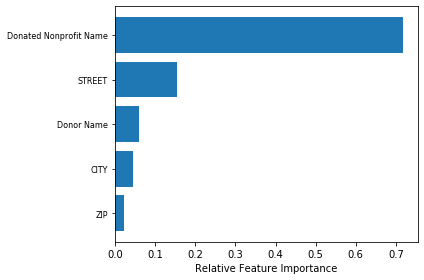

GaussianNB
MultinomialNB


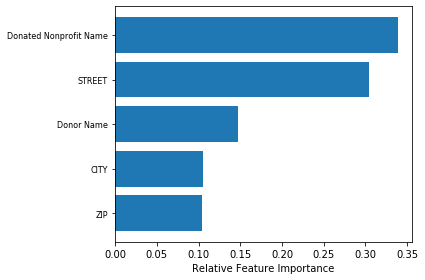

ComplementNB


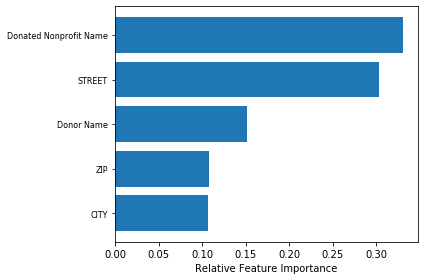

BernoulliNB


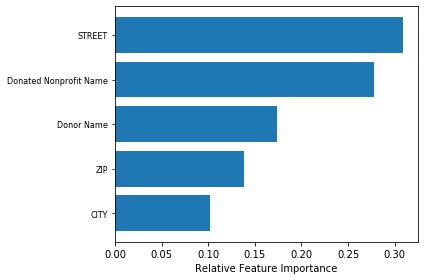

DecisionTreeClassifier


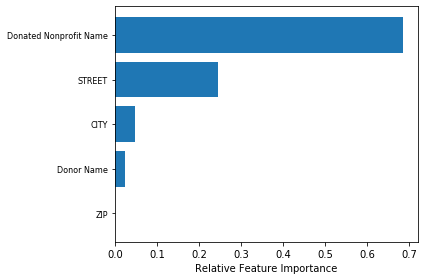

SGDClassifier


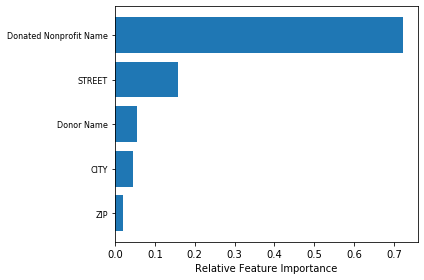

PassiveAggressiveClassifier


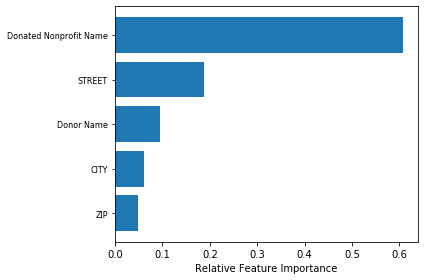

LinearSVC


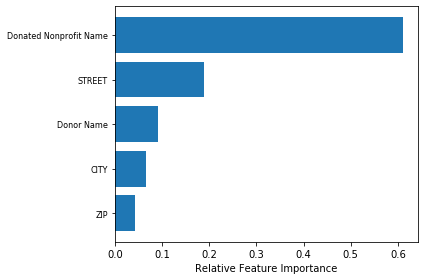

RandomForestClassifier


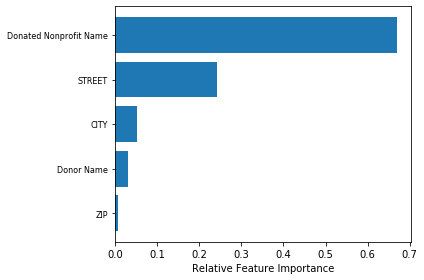

In [18]:
feature_names = vectorizer.get_feature_names()
for m in models:
    model = m['model']
    model.fit(X_train, y_train)
    print(m['label'])
    if m['label'] in ['DecisionTreeClassifier', 'RandomForestClassifier']:
        feature_value = model.feature_importances_[:-1]
    elif m['label'] in ['GaussianNB']:
        continue
    else:
        feature_value = model.coef_[0][:-1]

    feature_dict = {i: abs(j) for i, j in zip(feature_names, feature_value)}
    calculate_feature_importance(df_info)

## F.I. for categorical variables

In [4]:
sample_4 = pd.read_csv("Donor Data Sample4.csv")
sample_4.head()

,Donor ID,Donor First Name,Donor Last Name,Email,Gender,Phone,Employer,Job Title,Age,Home Address,...,Volunteered in the past,2019 Gift,2018 Gift,2017 Gift,2016 Gift,2015 Gift,2014 Gift,2013 Gift,2012 Gift,2011 Gift
0,1,Estrella,Plant,Estrella_Plant9353@nanoff.biz,Female,7-407-761-5587,Team Guard SRL,Food Technologist,45,6736 Udall Way,...,False,"$96,535.60","$35,990.85","$65,466.67","$74,071.05","$43,463.61","$91,870.99","$98,652.49","$16,559.39","$75,884.58"
1,2,Harry,Hooper,Harry_Hooper4978@nimogy.biz,Male,0-383-174-3353,Team Guard SRL,Business Broker,56,6932 Bethwin Road,...,False,"$55,681.79","$9,108.68","$6,440.71","$42,169.22","$99,415.06","$76,032.01","$15,683.99","$87,287.97","$9,083.66"
2,3,Stella,Armstrong,Stella_Armstrong2053@sheye.org,Female,1-788-858-0867,Telekom,Bookkeeper,55,6620 Enford Boulevard,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Ramon,Overson,Ramon_Overson7782@bulaffy.com,Male,4-332-485-2415,ExxonMobil,Operator,70,8615 Clerkenwell Drive,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Oliver,Brock,Oliver_Brock5011@deons.tech,Male,5-771-261-1701,UPC,HR Specialist,34,7371 Bury Crossroad,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = remove_rows_containg_all_null_values(sample_4)
print(df.shape)
df_info = remove_columns_unique_values(df, identify_info_columns(sample_4))
cat_col = identify_categorical_columns(df, df_info)
print("Categorical columns: {}".format(cat_col))

df_info['comb_text'] = df_info.apply(lambda x: ' '.join(x), axis=1)
processed_text = text_processing(list(df_info['comb_text']))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_text)
tfidf_matrix = X.todense()
tfidf_matrix.shape

(10000, 23)
Total training samples: 10000
Column: Donor ID, Null count: 0
Column: Donor First Name, Null count: 0
Column: Donor Last Name, Null count: 0
Column: Email, Null count: 0
Column: Gender, Null count: 0
Column: Phone, Null count: 0
Column: Employer, Null count: 0
Column: Job Title, Null count: 0
Column: Age, Null count: 0
Column: Home Address, Null count: 0
Column: City, Null count: 0
Column: State, Null count: 0
Column: Zip, Null count: 0
Column: Volunteered in the past, Null count: 0
_____________

Column: Donor ID, Unique count: 10000
Column: Donor First Name, Unique count: 457
Column: Donor Last Name, Unique count: 642
Column: Email, Unique count: 10000
Column: Gender, Unique count: 2
Column: Phone, Unique count: 10000
Column: Employer, Unique count: 30
Column: Job Title, Unique count: 60
Column: Age, Unique count: 56
Column: Home Address, Unique count: 9999
Column: City, Unique count: 107
Column: State, Unique count: 50
Column: Zip, Unique count: 9435
Column: Volunteered 

TypeError: ('sequence item 5: expected str instance, int found', 'occurred at index 0')

In [9]:
sample_3 = pd.read_csv("Donor Data Sample3.csv", encoding = "ISO-8859-1")
sample_3.head()

,Donor ID,Donor First Name,Donor Last Name,Gender,Phone,Email,State,Has Children,Married,Volunteered before,...,2018 Donations,2018 Donations Gave in the Area,2017 Donations,2016 Donations,2015 Donations,2014 Donations,2013 Donations,2012 Donations,2011 Donations,2010 Donations
0,000-04-3255,Danny,Kelly,Male,8-835-453-4445,Danny_Kelly6509@deavo.com,Vermont,Unknown,Unknown,Unknown,...,$0,Zoos & Aquariums,$0,$0,$0,"$4,361",$0,$0,$0,$0
1,000-06-5577,Daphne,Whitmore,Female,0-613-687-7372,Daphne_Whitmore6979@bretoux.com,Alaska,FALSE,TRUE,TRUE,...,$411,Youth Violence Prevention,"$7,840","$4,070",$155,$970,$0,$0,"$1,878",$469
2,000-11-5314,William,Nobbs,Male,5-210-841-3847,William_Nobbs2669@hourpy.biz,Kentucky,Unknown,Unknown,Unknown,...,$0,Youth Development Programs,$0,$0,$0,"$2,853",$0,$0,$0,$0
3,000-13-7832,Ruby,Brennan,Female,5-463-024-3544,Ruby_Brennan2800@nanoff.biz,Colorado,FALSE,TRUE,FALSE,...,"$1,839",Youth Development N.E.C.,"$8,652","$2,447","$14,867","$7,361",$0,$0,$575,"$3,112"
4,000-23-7053,Nathan,Gilmore,Unknown,0-806-625-5013,Nathan_Gilmore3982@supunk.biz,Maryland,Unknown,Unknown,Unknown,...,$0,Youth Development - Religious Leadership,$0,$0,$0,$0,$0,$0,$0,$0


In [10]:
df = remove_rows_containg_all_null_values(sample_3)
print(df.shape)
df_info = remove_columns_unique_values(df, identify_info_columns(sample_3))
cat_col = identify_categorical_columns(df, df_info)
print("Categorical columns: {}".format(cat_col))

df_info['comb_text'] = df_info.apply(lambda x: ' '.join(x), axis=1)
processed_text = text_processing(list(df_info['comb_text']))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_text)
tfidf_matrix = X.todense()
tfidf_matrix.shape

(10000, 37)
Total training samples: 10000
Column: Donor ID, Null count: 0
Column: Donor First Name, Null count: 0
Column: Donor Last Name, Null count: 0
Column: Gender, Null count: 0
Column: Phone, Null count: 0
Column: Email, Null count: 0
Column: State, Null count: 0
Column: Has Children, Null count: 0
Column: Married, Null count: 0
Column: Volunteered before, Null count: 0
Column: Engaged with Organization, Null count: 0
Column: Own Property, Null count: 0
Column: Past served on Board, Null count: 0
Column: Employer, Null count: 0
Column: Job Area, Null count: 0
Column: Salary Estimation, Null count: 0
Column: Retired?, Null count: 0
Column: Education, Null count: 0
Column: Education Area, Null count: 0
Column: Active outside Organization, Null count: 0
Column: Political Contribution, Null count: 0
Column: Donor Age, Null count: 0
Column: Joint Mailing Name, Null count: 0
Column: Military Affiliate/Veteran, Null count: 0
Column: Total Lifetime Donations, Null count: 0
_____________


(10000, 6553)